# 2A. Wind-Vision: Not calibrated, dynamic wind, with drag

Given: wind angle, vision angle, phi

Scenario details:
1. Dynamic wind
2. Body calibrations NOT known
3. Sensor calibrations NOT known
4. Motor calibrations NOT known
5. With drag

### Summary

To get zeta, need f_para AND f_perp to be non-zero. Need second order derivative, even in constant wind.

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

from symbolic_derivatives import directional_derivative, chain_rule_derivative, get_bigO, get_vars

In [2]:
sin = sp.sin
cos = sp.cos
tan = sp.tan

In [3]:
sp.init_printing()

### Define variables

In [4]:
W,zeta, W_z, \
  Wdot, zetadot, \
  theta,thetadot,thetaddot,\
  phi,phidot,phiddot,\
  gamma, gammadot,\
  A_para, Adot_para,\
  A_perp, Adot_perp,\
  beta, betadot, \
  V_perp, V_para, V_z, \
  Vdot_perp, Vdot_para, Vdot_z, \
  m, d1, d2, i, z, zdot \
  = sp.symbols([\
  'W','zeta', 'W_z', \
  'Wdot', 'zetadot', \
  'theta','thetadot', 'thetaddot',\
  'phi','phidot', 'phiddot', \
  'gamma', 'gammadot',\
  'A_para', 'Adot_para',\
  'A_perp', 'Adot_perp', \
  'beta', 'betadot',\
   'V_perp', 'V_para', 'V_z', \
   'Vdot_perp', 'Vdot_para', 'Vdot_z',\
   'm', 'd1', 'd2', 'i', 'z', 'zdot'])


thrust_para, thrust_perp, thrust_z = sp.symbols(['thrust_para', 'thrust_perp', 'thrust_z'])

u_phi, u_para, u_perp, u_z = sp.symbols(['u_phi', 'u_para', 'u_perp', 'u_z'])

km1, km2, km3, km4, km5 = sp.symbols(['km1', 'km2', 'km3', 'km4', 'km5'])
ks1, ks2, ks3, ks4, ks5 = sp.symbols(['ks1', 'ks2', 'ks3', 'ks4', 'ks5'])

In [5]:
if 0: # No drag
    c_para = 0
    c_perp = 0
    c_z = 0
    c_phi = 0
else:
    c_para,c_perp,c_phi,c_z = sp.symbols(['c_para', 'c_perp', 'c_phi', 'c_z'])

### Airspeed

In [6]:
h_A_para = V_para - W*cos(phi-zeta)
h_A_para

In [7]:
h_A_perp = V_perp + W*sin(phi-zeta)
h_A_perp

### Sum of forces in parallel and perpendicular directions

In [8]:
F_para = -c_para*h_A_para + u_para*km1
F_para

In [9]:
F_perp = -c_perp*h_A_perp + u_perp*km3
F_perp

### Vdot para and perp, taking into account derivative of body coordinates

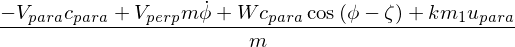

In [10]:
Vdot_para = 1/m*(F_para) + V_perp*phidot
sp.simplify(sp.expand(Vdot_para))

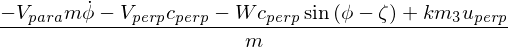

In [11]:
Vdot_perp = 1/m*(F_perp) - V_para*phidot
sp.simplify(sp.expand(Vdot_perp))

### Observability

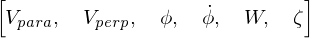

In [12]:
x = [V_para,
     V_perp,
     phi,
     phidot,
     W,
     zeta]
x

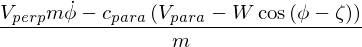

In [13]:
Vdot_para_f_0 = sp.simplify( Vdot_para - sp.Derivative(Vdot_para, u_para).doit()*u_para )
Vdot_para_f_0

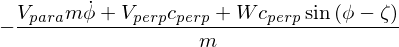

In [14]:
Vdot_perp_f_0 = sp.simplify( Vdot_perp - sp.Derivative(Vdot_perp, u_perp).doit()*u_perp )
Vdot_perp_f_0

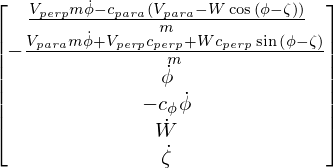

In [15]:
if 0: # constant wind
    f_0 = [sp.simplify( Vdot_para_f_0 ),
           sp.simplify( Vdot_perp_f_0 ),
           phidot,
           -c_phi*phidot,
           0,
           0]
else:
    f_0 = [sp.simplify( Vdot_para_f_0 ),
           sp.simplify( Vdot_perp_f_0 ),
           phidot,
           -c_phi*phidot,
           Wdot,
           zetadot]
sp.Matrix(f_0)

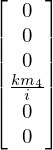

In [16]:
f_phidot = [  0,
              0,
              0,
              km4/i,
              0,
              0]
sp.Matrix(f_phidot)

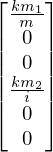

In [17]:
f_para = [sp.Derivative(Vdot_para, u_para).doit(),
          0,
          0,
          km2/i, # models a damaged wing
          0,
          0]
sp.Matrix(f_para)

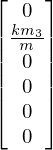

In [18]:
f_perp = [0,
          sp.Derivative(Vdot_perp, u_perp).doit(),
          0,
          0,
          0,
          0]
sp.Matrix(f_perp)

In [19]:
f_0 = sp.Matrix(f_0)
f_phidot = 1*sp.Matrix(f_phidot) # run motors in anti direction
f_para = 1*sp.Matrix(f_para) # run motors together
f_perp = 1*sp.Matrix(f_perp) # 

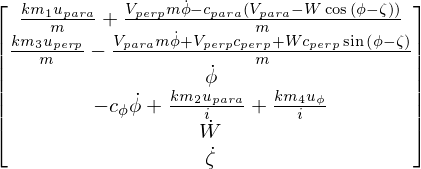

In [20]:
full_dynamics = f_0 + u_phi*f_phidot + u_para*f_para + u_perp*f_perp #+ u_z*f_z
full_dynamics

### Some values

In [21]:
s = {V_para: 2, V_perp: 3, V_z: 5,
     zeta: 7, W: 13, W_z: 17,
     zetadot: 19, Wdot: 23, 
     #c_para: 29, c_perp: 31, c_z: 37, c_phi: 41,
     phi:43, phidot: 47,
     u_para: 53, u_perp: 59, u_phi: 61, u_z: 67,
     z: 71, zdot: 73,
     m: 79, d1: 83, d2: 89, i: 97,
     km1: 101, km2: 103, km3: 107, km4: 109, km5: 113,
     ks1: 127, ks2: 131, ks3: 137, ks4: 139, ks5: 149,
    }

us = {u_para: 53, u_perp: 59, u_phi: 61, u_z: 67,}
#motor_ks = {km1: 101, km2: 103, km3: 107, km4: 109, km5: 113,}
motor_ks = {km1: 1, km2: 0, km3: 1, km4: 1, km5: 1,}
cs = {c_para: 29, c_perp: 31, c_z: 37, c_phi: 41,}
#cs = {c_para: 0, c_perp: 0, c_z: 0, c_phi: 0,} # no drag
#mis = {m: 79, i: 97,}
mis = {m: 1, i: 1,}

### Observability analysis

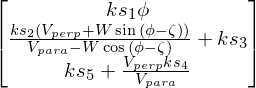

In [22]:
h = sp.Matrix([ks1*phi, 
               ks2*h_A_perp/h_A_para + ks3, 
               ks4*V_perp/V_para + ks5, 
               #zeta,
              ])
h

### With just h

Rank O =  3
Rank {O; zeta} =  4

Not observable.

x_tilde = 


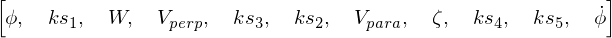

In [23]:
O = h
jx = get_vars(sp.Matrix.vstack(O, sp.Matrix([x]).T ) )
J = O.jacobian( jx ).subs(s).subs(cs)
R_nozeta = np.linalg.matrix_rank(np.matrix(J, dtype=float))

# augment with zeta
Ozeta = O.row_insert(0, sp.Matrix([zeta]))
Jzeta = Ozeta.jacobian( jx ).subs(s).subs(cs)
R_zeta = np.linalg.matrix_rank(np.matrix(Jzeta, dtype=float))

print('Rank O = ', R_nozeta)
print('Rank {O; zeta} = ', R_zeta)
print()

if R_nozeta == R_zeta:
    print('Observable!')
else:
    print('Not observable.')

    print()
print('x_tilde = ')
jx

### With one derivative, no control

Rank O =  6
Rank {O; zeta} =  7

Not observable.

x_tilde = 


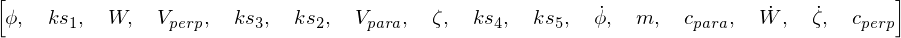

In [24]:
O = h
bigO = get_bigO(h, 
                x, 
                [f_0], 
               )
O = sp.Matrix.vstack(*bigO) 
jx = get_vars(sp.Matrix.vstack(O, sp.Matrix([x]).T ) )
J = O.jacobian( jx ).subs(s).subs(cs)
R_nozeta = np.linalg.matrix_rank(np.matrix(J, dtype=float))

# augment with zeta
Ozeta = O.row_insert(0, sp.Matrix([zeta]))
Jzeta = Ozeta.jacobian( jx ).subs(s).subs(cs)
R_zeta = np.linalg.matrix_rank(np.matrix(Jzeta, dtype=float))

print('Rank O = ', R_nozeta)
print('Rank {O; zeta} = ', R_zeta)
print()

if R_nozeta == R_zeta:
    print('Observable!')
else:
    print('Not observable.')

    print()
print('x_tilde = ')
jx

### With one derivative, u_para control

Rank O =  8
Rank {O; zeta} =  9

Not observable.

x_tilde = 


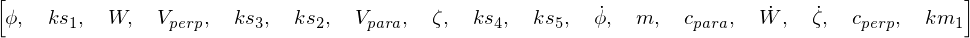

In [25]:
O = h
bigO = get_bigO(h, 
                x, 
                [f_0, 
                 f_para], 
               )
O = sp.Matrix.vstack(*bigO) 
jx = get_vars(sp.Matrix.vstack(O, sp.Matrix([x]).T ) )
J = O.jacobian( jx ).subs(s).subs(cs)
R_nozeta = np.linalg.matrix_rank(np.matrix(J, dtype=float))

# augment with zeta
Ozeta = O.row_insert(0, sp.Matrix([zeta]))
Jzeta = Ozeta.jacobian( jx ).subs(s).subs(cs)
R_zeta = np.linalg.matrix_rank(np.matrix(Jzeta, dtype=float))

print('Rank O = ', R_nozeta)
print('Rank {O; zeta} = ', R_zeta)
print()

if R_nozeta == R_zeta:
    print('Observable!')
else:
    print('Not observable.')

    print()
print('x_tilde = ')
jx

### With one derivative, both controls

Rank O =  10
Rank {O; zeta} =  11

Not observable.

x_tilde = 


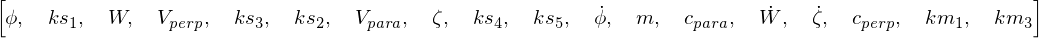

In [26]:
O = h
bigO = get_bigO(h, 
                x, 
                [f_0, 
                 f_para,
                 f_perp], 
               )
O = sp.Matrix.vstack(*bigO) 
jx = get_vars(sp.Matrix.vstack(O, sp.Matrix([x]).T ) )
J = O.jacobian( jx ).subs(s).subs(cs)
R_nozeta = np.linalg.matrix_rank(np.matrix(J, dtype=float))

# augment with zeta
Ozeta = O.row_insert(0, sp.Matrix([zeta]))
Jzeta = Ozeta.jacobian( jx ).subs(s).subs(cs)
R_zeta = np.linalg.matrix_rank(np.matrix(Jzeta, dtype=float))

print('Rank O = ', R_nozeta)
print('Rank {O; zeta} = ', R_zeta)
print()

if R_nozeta == R_zeta:
    print('Observable!')
else:
    print('Not observable.')

    print()
print('x_tilde = ')
jx

### With two derivatives, and both controls

Rank O =  17
Rank {O; zeta} =  17

Observable!
x_tilde = 


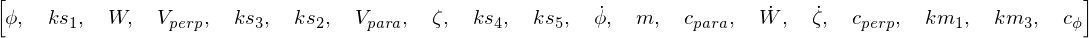

In [27]:
O = h
bigO = get_bigO(h, 
                x, 
                [f_0, 
                 f_para,
                 f_perp], 
               )

bigO2 = get_bigO(sp.Matrix.vstack(*bigO), x, [f_0])
O = sp.Matrix.vstack(*bigO, *bigO2)

jx = get_vars(sp.Matrix.vstack(O, sp.Matrix([x]).T ) )
J = O.jacobian( jx ).subs(s).subs(cs)
R_nozeta = np.linalg.matrix_rank(np.matrix(J, dtype=float))

# augment with zeta
Ozeta = O.row_insert(0, sp.Matrix([zeta]))
Jzeta = Ozeta.jacobian( jx ).subs(s).subs(cs)
R_zeta = np.linalg.matrix_rank(np.matrix(Jzeta, dtype=float))

print('Rank O = ', R_nozeta)
print('Rank {O; zeta} = ', R_zeta)
print()

if R_nozeta == R_zeta:
    print('Observable!')
else:
    print('Not observable.')

    print()
print('x_tilde = ')
jx

### With two derivatives, and one control

Rank O =  13
Rank {O; zeta} =  14

Not observable.

x_tilde = 


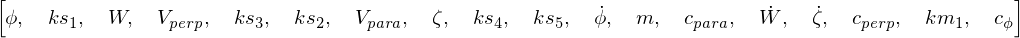

In [28]:
O = h
bigO = get_bigO(h, 
                x, 
                [f_0, 
                 f_para], 
               )

bigO2 = get_bigO(sp.Matrix.vstack(*bigO), x, [f_0])
O = sp.Matrix.vstack(*bigO, *bigO2)

jx = get_vars(sp.Matrix.vstack(O, sp.Matrix([x]).T ) )
J = O.jacobian( jx ).subs(s).subs(cs)
R_nozeta = np.linalg.matrix_rank(np.matrix(J, dtype=float))

# augment with zeta
Ozeta = O.row_insert(0, sp.Matrix([zeta]))
Jzeta = Ozeta.jacobian( jx ).subs(s).subs(cs)
R_zeta = np.linalg.matrix_rank(np.matrix(Jzeta, dtype=float))

print('Rank O = ', R_nozeta)
print('Rank {O; zeta} = ', R_zeta)
print()

if R_nozeta == R_zeta:
    print('Observable!')
else:
    print('Not observable.')

    print()
print('x_tilde = ')
jx